In [2]:
import sys
import os
import json
import glob
import h5py

import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
importlib.reload(util_figures)
import util_stimuli
importlib.reload(util_stimuli)
import util_misc
importlib.reload(util_misc)

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'


In [19]:
def get_ANF_tuning(cf,
                   kwargs_nervegram_update={},
                   list_f0=np.exp(np.linspace(np.log(1e2), np.log(1e4), 100)),
                   list_dBSPL=np.arange(20, 101, 2)):
    '''
    '''
    kwargs_nervegram = {
        'nervegram_dur': 0.050,
        'nervegram_fs': 20e3,
        'buffer_start_dur': 0.070,
        'buffer_end_dur': 0.010,
        'pin_fs': 100e3,
        'pin_dBSPL_flag': 0,
        'pin_dBSPL': None,
        'species': 2,
        'bandwidth_scale_factor': 1.0,
        'cf_list': None,
        'num_cf': 1,
        'min_cf': cf,
        'max_cf': cf,
        'max_spikes_per_train': 500,
        'num_spike_trains': 1,
        'cohc': 1.0,
        'cihc': 1.0,
        'IhcLowPass_cutoff': 3000,
        'IhcLowPass_order': 7,
        'spont': 70.0,
        'noiseType': 0,
        'implnt': 0,
        'tabs': 6e-4,
        'trel': 6e-4,
        'random_seed': None,
        'return_vihcs': False,
        'return_meanrates': True,
        'return_spike_times': False,
        'return_spike_tensor_sparse': False,
        'return_spike_tensor_dense': False,
        'nervegram_spike_tensor_fs': 100e3,
    }
    sr = 100e3
    dur = kwargs_nervegram['nervegram_dur']
    dur += kwargs_nervegram['buffer_start_dur']
    dur += kwargs_nervegram['buffer_end_dur']
    t = np.arange(0, dur, 1/sr)
    X = np.zeros([list_f0.shape[0], list_dBSPL.shape[0]])
    for itr0, f0 in enumerate(list_f0):
        for itr1, dBSPL in enumerate(list_dBSPL):
            y = np.sin(2 * np.pi * f0 * t + (np.pi/2 * np.random.rand()))
            y = util_stimuli.set_dBSPL(y, dBSPL)
            out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram)
            X[itr0, itr1] = np.mean(np.squeeze(out_dict['nervegram_meanrates']))
    return list_f0, list_dBSPL, X


list_f0, list_dBSPL, X = get_ANF_tuning(cf=500)



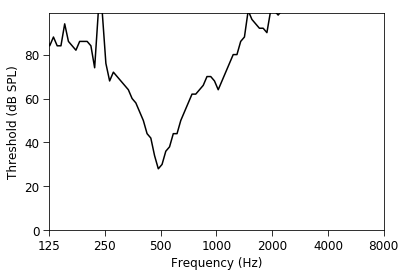

In [23]:
fig, ax = plt.subplots()

list_threshold = 100 * np.ones_like(list_f0)
for itr0, f0 in enumerate(list_f0):
    
    thresh = list_dBSPL[X[itr0] > 77]
    if len(thresh) > 0:
        list_threshold[itr0] = thresh[0]
    
ax.plot(list_f0, list_threshold, 'k-')

list_cf = [250.0, 5e2, 1e3, 2e3, 4e3]
xticks = [list_cf[0]/2] + list_cf + [list_cf[-1]*2]
ax = util_figures.format_axes(
    ax,
    xscale='log',
    str_xlabel='Frequency (Hz)',
    str_ylabel='Threshold (dB SPL)',
    str_title=None,
    xticks=xticks,
    xticklabels=np.array(xticks).astype(int),
    xticks_minor=[],
    xlimits=[xticks[0], xticks[-1]],
    ylimits=[0, 99])

plt.show()


In [ ]:
# parallel_run_wrapper = functools.partial(parallel_run_f0dl_experiment,
#                                          expt_dict=expt_dict,
#                                          unique_phase_mode_list=unique_phase_mode_list,
#                                          unique_low_harm_list=unique_low_harm_list,
#                                          max_pct_diff=max_pct_diff,
#                                          noise_stdev=noise_stdev,
#                                          bin_width=bin_width,
#                                          mu=mu,
#                                          threshold_value=threshold_value,
#                                          use_empirical_f0dl_if_possible=use_empirical_f0dl_if_possible)
# # Call the wrapper in parallel processes using multiprocessing.Pool
# with multiprocessing.Pool(processes=np.min([N, max_processes])) as pool:    
#     parallel_results = pool.map(parallel_run_wrapper, range(0, N))
#     for (par_idx, sub_results_dict) in parallel_results:
#         for key in sub_results_dict.keys():
#             results_dict[key][par_idx] = sub_results_dict[key]
